# Import Data from Google Drive

In [1]:
import pandas as pd
import requests
from io import StringIO
file_id = "10Hzs1GFe8XqxzmItJ84S780Md3a48fIh"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = requests.get(download_url)
if response.status_code == 200:
    content = StringIO(response.text)
    df = pd.read_csv(content,skiprows=1).iloc[2:]  # Add sep='\t' or other parameters if needed
    # Convert 'timestamp' to datetime
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# Convert all other columns to float
    for col in df.columns:
        if col != 'TIMESTAMP':
            df[col] = df[col].astype(float)
else:
    print("Failed to download file:", response.status_code)



# Calibrate and Rename Sensors

In [2]:
def ToppEq(x):
    """ Using the topp equation to calculate VWC in percentage from e"""
    VWC = 4.3 * 10e-6 * x**3 - 5.5 * 10e-4 * x**2 +2.92 * 10e-2 * x - 5.3 * 10e-2
    return VWC


cal = {"DateTime" : df["TIMESTAMP"], 
       "HiC HiM 1 Upper Temp": df["T(1)"],
       "HiC HiM 1 Lower Temp": df["T(2)"],
       "HiC HiM 2 Upper Temp": df["T(3)"],
       "HiC HiM 2 Lower Temp": df["T(4)"],
       "HiC HiM 3 Upper Temp": df["T(5)"],
       "HiC HiM 3 Lower Temp": df["T(6)"],
       
       "HiC LoM 1 Upper Temp": df["T(7)"],
       "HiC LoM 1 Lower Temp": df["T(8)"],
       "HiC LoM 2 Upper Temp": df["T(9)"],
       "HiC LoM 2 Lower Temp": df["T(10)"],
       "HiC LoM 3 Upper Temp": df["T(11)"],
       #"HiC LoM 3 Lower Temp": df["T(12)"],

       "LoC HiM 1 Upper Temp": df["T_2(1)"],
       "LoC HiM 1 Lower Temp": df["T_2(2)"],
       "LoC HiM 2 Upper Temp": df["T_2(3)"],
       "LoC HiM 2 Lower Temp": df["T_2(4)"],
       "LoC HiM 3 Upper Temp": df["T_2(5)"],
       "LoC HiM 3 Lower Temp": df["T_2(6)"],
       
       "LoC LoM 1 Upper Temp": df["T_2(7)"],
       "LoC LoM 1 Lower Temp": df["T_2(8)"],
       "LoC LoM 2 Upper Temp": df["T_2(9)"],
       "LoC LoM 2 Lower Temp": df["T_2(10)"],
       "LoC LoM 3 Upper Temp": df["T_2(11)"],
       #"LoC LoM 3 Lower Temp": df["T_2(12)"],
       
       
       "HiC HiM 1 Upper VWC": ToppEq(df["e(1)"]),
       "HiC HiM 1 Lower VWC": ToppEq(df["e(2)"]),
       "HiC HiM 2 Upper VWC": ToppEq(df["e(3)"]),
       "HiC HiM 2 Lower VWC": ToppEq(df["e(4)"]),
       "HiC HiM 3 Upper VWC": ToppEq(df["e(5)"]),
       "HiC HiM 3 Lower VWC": ToppEq(df["e(6)"]),
       
       "HiC LoM 1 Upper VWC": ToppEq(df["e(7)"]),
       "HiC LoM 1 Lower VWC": ToppEq(df["e(8)"]),
       "HiC LoM 2 Upper VWC": ToppEq(df["e(9)"]),
       "HiC LoM 2 Lower VWC": ToppEq(df["e(10)"]),
       "HiC LoM 3 Upper VWC": ToppEq(df["e(11)"]),
       #"HiC LoM 3 Lower VWC": ToppEq(df["e(12)"]),

       "LoC HiM 1 Upper VWC": ToppEq(df["e_2(1)"]),
       "LoC HiM 1 Lower VWC": ToppEq(df["e_2(2)"]),
       "LoC HiM 2 Upper VWC": ToppEq(df["e_2(3)"]),
       "LoC HiM 2 Lower VWC": ToppEq(df["e_2(4)"]),
       "LoC HiM 3 Upper VWC": ToppEq(df["e_2(5)"]),
       "LoC HiM 3 Lower VWC": ToppEq(df["e_2(6)"]),
       
       "LoC LoM 1 Upper VWC": ToppEq(df["e_2(7)"]),
       "LoC LoM 1 Lower VWC": ToppEq(df["e_2(8)"]),
       "LoC LoM 2 Upper VWC": ToppEq(df["e_2(9)"]),
       "LoC LoM 2 Lower VWC": ToppEq(df["e_2(10)"]),
       "LoC LoM 3 Upper VWC": ToppEq(df["e_2(11)"]),
       #"LoC LoM 3 Lower VWC": ToppEq(df["e_2(12)"]),
      }

df2 = df.assign(**cal)[list(cal.keys())]

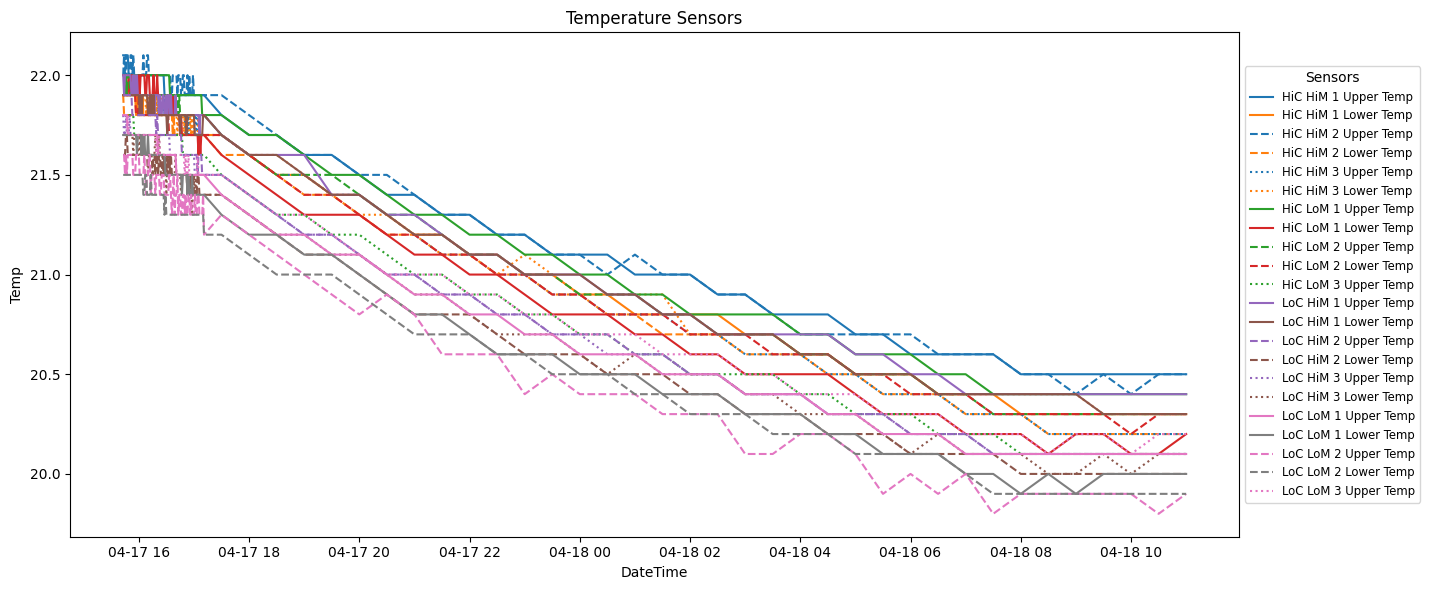

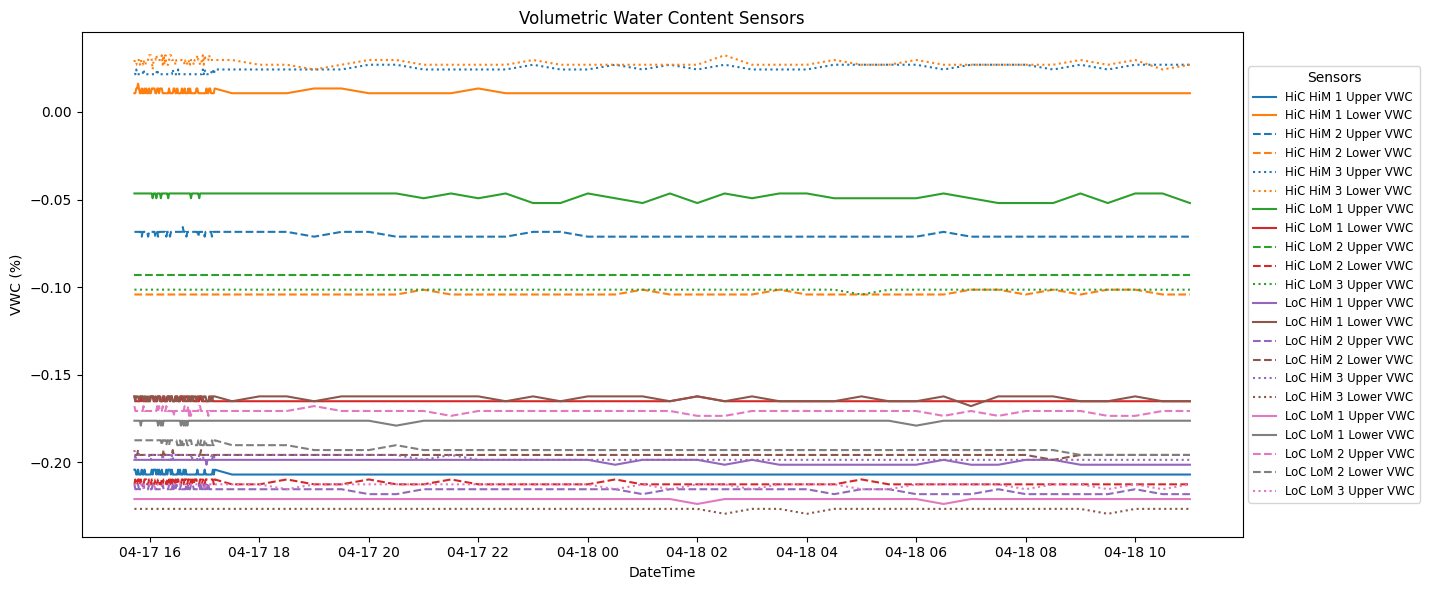

In [3]:
import re
import matplotlib.pyplot as plt

# 1) Identify your datetime index, temp cols, and vwc cols
time_col    = 'DateTime'
temp_cols   = [c for c in df2.columns if 'Temp' in c]
vwc_cols    = [c for c in df2.columns if 'VWC'  in c]

# 2) Build a grouping key that strips out the number AND the suffix word ("Temp"/"VWC")
def group_key(col):
    no_num  = re.sub(r'\b\d+\b', '', col)                # remove the replicate number
    no_suff = re.sub(r'\b(Temp|VWC)\b', '', no_num)      # remove the trailing metric
    return no_suff.strip()

# 3) Get unique groups (ordering preserved)
groups = []
for c in temp_cols:
    k = group_key(c)
    if k not in groups:
        groups.append(k)

# 4) Build a color map (uses Matplotlib defaults)
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {grp: colors[i % len(colors)] 
             for i, grp in enumerate(groups)}

# 5) Line styles for replicate numbers 1,2,3
linestyles = ['-', '--', ':']

# 6) Plot TEMPS with side legend
plt.figure(figsize=(18,6))
for col in temp_cols:
    grp    = group_key(col)
    number = int(re.search(r'\b(\d+)\b', col).group(1))
    plt.plot(df2[time_col], df2[col],
             color     = color_map[grp],
             linestyle = linestyles[number-1],
             label     = col)

plt.title('Temperature Sensors')
plt.xlabel(time_col)
plt.ylabel('Temp')
legend = plt.legend(loc='center left',
                    bbox_to_anchor=(1, 0.5),
                    ncol=1,
                    fontsize='small',
                    title='Sensors')
plt.tight_layout(rect=[0, 0, 0.8, 1])   # leave right margin for legend


# 7) Plot VWCs with side legend
plt.figure(figsize=(18,6))
for col in vwc_cols:
    grp    = group_key(col)
    number = int(re.search(r'\b(\d+)\b', col).group(1))
    plt.plot(df2[time_col], df2[col],
             color     = color_map[grp],
             linestyle = linestyles[number-1],
             label     = col)

plt.title('Volumetric Water Content Sensors')
plt.xlabel(time_col)
plt.ylabel('VWC (%)')
plt.legend(loc='center left',
           bbox_to_anchor=(1, 0.5),
           ncol=1,
           fontsize='small',
           title='Sensors')
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.show()


In [4]:
import pandas as pd
from datetime import datetime, timedelta
import sys

def error_log(df, time_col='TIMESTAMP', threshold_min=40):
    # 1. Ensure your time column is datetime
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # 2. Find most recent timestamp
    recent_ts = df[time_col].max()
    now = datetime.now()    
    delta = now - recent_ts
    
    # 3. Print status (red if stale)
    warning = delta > timedelta(minutes=threshold_min)
    msg = (f"Last data point @ {recent_ts} — "
           f"{int(delta.total_seconds()//60)} min {int(delta.total_seconds()%60)} s ago")
    if warning:
        # ANSI escape for red text; resets at end
        print(f"\033[91m⚠️  STALE DATA: {msg}\033[0m", file=sys.stderr)
    else:
        print(f"✅ Recent data: {msg}")
    
    # 4. Melt to long form and filter zeros / NaNs
    long = df.melt(id_vars=[time_col],
                   var_name='column',
                   value_name='value')
    mask = long['value'].isna() | (long['value'] == 0)
    error_entries = (
        long.loc[mask]
            .sort_values(time_col, ascending=False)
            .reset_index(drop=True)
    )
    
    return error_entries


# ————— Example Usage —————
errors = error_log(df, time_col='TIMESTAMP', threshold_min=40)
display(errors.head(25))


✅ Recent data: Last data point @ 2025-04-18 11:00:00 — 30 min 46 s ago


,TIMESTAMP,column,value
0,2025-04-18 11:00:00,T(12),0.0
1,2025-04-18 11:00:00,e(12),NaN
2,2025-04-18 11:00:00,e_2(12),NaN
3,2025-04-18 11:00:00,T_2(12),0.0
4,2025-04-18 10:30:00,T(12),0.0
5,2025-04-18 10:30:00,T_2(12),0.0
6,2025-04-18 10:30:00,e(12),NaN
7,2025-04-18 10:30:00,e_2(12),NaN
8,2025-04-18 10:00:00,e(12),NaN
9,2025-04-18 10:00:00,T_2(12),0.0


In [6]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime, timedelta
import dash_bootstrap_components as dbc

# Your dataframe
df =df2

# Your error logging function
def error_log(df, time_col="DateTime", threshold_min=40):
    now = datetime.now()
    most_recent = df[time_col].max()
    delta = now - most_recent

    color = "red" if delta.total_seconds() > threshold_min * 60 else "black"
    status_msg = f"Last update: {most_recent} ({delta})"

    errors = []
    for col in df.columns:
        if col == time_col:
            continue
        recent = df[df[col].isna() | (df[col] == 0)]
        for _, row in recent.iterrows():
            errors.append((row[time_col], col))

    error_df = pd.DataFrame(errors, columns=["Timestamp", "Column"]).sort_values("Timestamp", ascending=False)
    return html.Div([
        html.P(status_msg, style={"color": color, "fontWeight": "bold"}),
        html.Hr(),
        html.P("Recent errors:"),
        dbc.Table.from_dataframe(error_df.head(10), striped=True, bordered=True, hover=True)
    ])

# Create app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Plotly graph
fig = go.Figure()
for col in df.columns:
    if "Temp" in col:
        fig.add_trace(go.Scatter(x=df["DateTime"], y=df[col], name=col))

# Layout
app.layout = html.Div([
    html.H2("Sensor Dashboard"),
    dcc.Graph(figure=fig),
    html.Div(error_log(df))
])

# Run app
if __name__ == '__main__':
    app.run(debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run.